In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import pandas as pd
import cv2
import matplotlib
import matplotlib.pyplot as plt

import os
from xml.etree import ElementTree as ET
from numpy import zeros, asarray

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


In [2]:
class BirdSoundsConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "birdsounds"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 10  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = BirdSoundsConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                23
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [6]:
class BirdSoundsDataset(utils.Dataset):
    """Generates the dataset. The dataset consists of spectrogram images
    of birdsounds.
    The images are generated on the fly.
    """

    def load_dataset(self, count, df, img_path, ann_path):
        """Generate the requested number of images.
        count: number of images to generate.
        df: is the dataframe 
        img_path, ann_path: the path to the generated spectrogram images and it's mask annotation.

        """
        # Add classes
        self.add_class("birdsounds", 1, "Common_Blackbird")
        self.add_class("birdsounds", 2, "Common_Chiffchaff")
        self.add_class("birdsounds", 3, "Common_Whitethroat")
        self.add_class("birdsounds", 4, "Eurasian_Blue_Tit")
        self.add_class("birdsounds", 5, "Eurasian_Tree_Sparrow")
        self.add_class("birdsounds", 6, "Great_Tit")
        self.add_class("birdsounds", 7, "Willow_Warbler")
        self.add_class("birdsounds", 8, "Yellowhammer")
        self.add_class("birdsounds", 9, "Corn_Bunting")
        self.add_class("birdsounds", 10, "Common_Chaffinch")
        # Add images
        #Images are generated on the fly in load_image().
        classes = 10
        self.df = df
        img_per_class = int(count/classes)
        df_per_class = df.groupby("class").head(img_per_class)

        for row in df_per_class.iloc:
            i = row["id"]        
            img_path_ = img_path + str(i) + ".png"
            ann_path_ = ann_path + str(i) + '.xml'

            self.add_image("birdsounds", image_id=i, path=img_path_, annotation=ann_path_)


    def load_mask(self, image_id):
        """Generate instance masks for spectrogram of the given image ID from the annotation.
        """
        info = self.image_info[image_id]

        path = info['annotation']
        boxes, w, h, labels = self.extract_boxes(path)
        mask = np.zeros([h, w, len(boxes)], dtype='uint8')
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            label = labels[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            mask[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index(label))
             
        class_ids = np.array(class_ids )

        return mask.astype(np.bool), class_ids.astype(np.int32)

    # A helper method to extract the bounding boxes from the annotation file
    def extract_boxes(self, filename):
        tree = ET.parse(filename)

        root = tree.getroot()

        boxes = list()
        labels = list()
        for obj in root.findall('.//object'):
            label = obj.find('name').text
            box = obj.find('.//bndbox')

            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            labels.append(label)
            boxes.append(coors)

        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height, labels

In [4]:
df = pd.read_csv("datasets/dataset.csv", index_col=0)

In [7]:
dataset_dir = "datasets"
img_path = dataset_dir + '/images/'
ann_path = dataset_dir + '/annots/'
# shuffle data
df = df.sample(frac = 1)
# Training dataset
dataset_train = BirdSoundsDataset()
dataset_train.load_dataset(40, df, img_path, ann_path)
dataset_train.prepare()

# shuffle data
df = df.sample(frac = 1)
# Validation dataset
dataset_val = BirdSoundsDataset()
dataset_val.load_dataset(10, df, img_path, ann_path)
dataset_val.prepare()

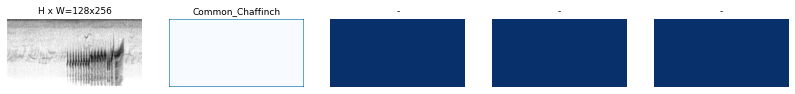

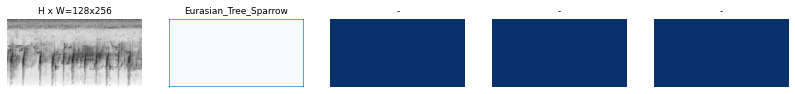

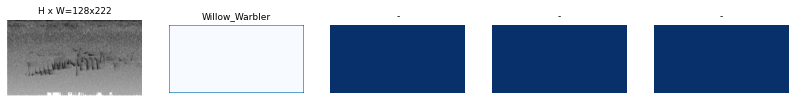

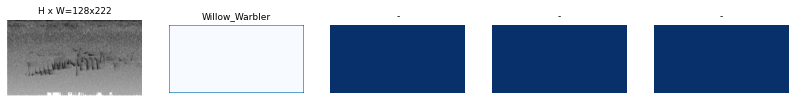

In [8]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [9]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [10]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [10]:
model.keras_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=8, 
            layers='heads')

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

Checkpoint Path:  /deepmatter/mask_rcnn/logs/shapes2017102802/mask_rcnn_{epoch:04d}.h5
Starting at epoch 0. LR=0.0002

Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b      

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
100/100 [==============================] - 86s - loss: 11.4006 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.8409 - mrcnn_class_loss: 0.1576 - mrcnn_bbox_loss: 0.0902 - mrcnn_mask_loss: 0.1977 - val_loss: 11.4376 - val_rpn_class_loss: 0.0220 - val_rpn_bbox_loss: 1.0068 - val_mrcnn_class_loss: 0.1172 - val_mrcnn_bbox_loss: 0.0683 - val_mrcnn_mask_loss: 0.1278


## Detection

In [12]:
class InferenceConfig(BirdSoundsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  g:\birdSounds\Mask_RCNN\logs\birdsounds20221005T1152\mask_rcnn_birdsounds_0008.h5
Re-starting from epoch 8


original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (23,)                 min:    0.00000  max:  256.00000  int32
gt_class_id              shape: (1,)                  min:    8.00000  max:    8.00000  int32
gt_bbox                  shape: (1, 4)                min:    1.00000  max:  255.00000  int32
gt_mask                  shape: (256, 256, 1)         min:    0.00000  max:    1.00000  bool


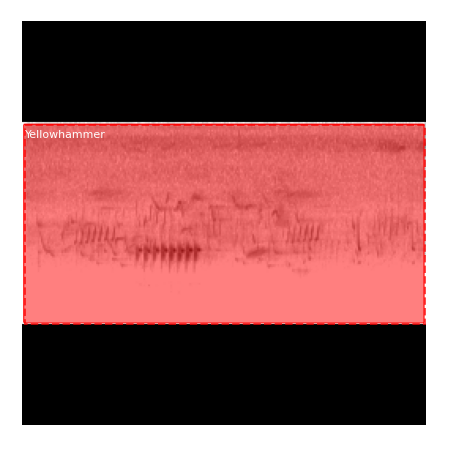

In [13]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
GroundTruth: Yellowhammer


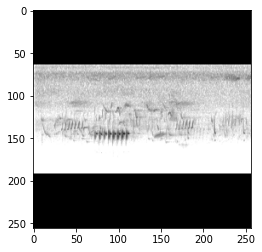

In [16]:
results = model.detect([original_image], verbose=1)

r = results[0]
for i in range(len(gt_class_id)):
    print("GroundTruth: {}".format(dataset_train.class_names[gt_class_id[i]]))

for i in range(len(r['class_ids'])):
    print("Predicted class: {}\Confidence Score: {}".format(dataset_val.class_names[r['class_ids'][i]], r['scores'][i]))

plt.imshow(original_image)

## Evaluation

In [21]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
test_samples = 10
image_ids = np.random.choice(dataset_val.image_ids, test_samples)
APs = []
grountruth_class_ids = []
predicted_class_ids = []
i=0
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP

    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    if (gt_class_id  in r["class_ids"]):
        i+=1
    grountruth_class_ids.append(gt_class_id)
    predicted_class_ids.append(r["class_ids"])
print("Test Accuracy: ", i/test_samples)
print("mAP: ", np.mean(APs))

Test Accuracy:  0.9
mAP:  0.9
